### SVHN Preprocessing
This notebook implements SVHN pre-processing. The key steps are:

1. Read in some sample images and play with them.
2. Pull in full data (a) Extract labels and dimensions for each bounding box (height, width, left, top); (b) Resize and crop around the bounding box for each image; (c) Store in something more useful for python, such as a pickle file.

In [1]:
import scipy.ndimage as img
import scipy.misc as misc
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import os
import sklearn.preprocessing as skproc
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
import cPickle as pkl
%matplotlib inline

In [2]:
train_struct_loc = '/Users/pjmartin/Documents/Udacity/MachineLearningProgram/Project5/udacity-mle-project5/data/train/digitStruct.mat'
test_struct_loc = '/Users/pjmartin/Documents/Udacity/MachineLearningProgram/Project5/udacity-mle-project5/data/test/digitStruct.mat'
train_loc_root = '/Users/pjmartin/Documents/Udacity/MachineLearningProgram/Project5/udacity-mle-project5/data/train/'
test_loc_root = '/Users/pjmartin/Documents/Udacity/MachineLearningProgram/Project5/udacity-mle-project5/data/test/'
img_loc1 = train_loc_root + '1.png'
img_loc1_test = test_loc_root + '12433.png'
# read in as B/W
# img1 = img.imread(img_loc1)
img1 = img.imread(img_loc1,mode='L')
img1_test = img.imread(img_loc1_test,mode='L')

(350, 741)
109


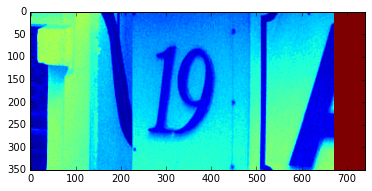

In [3]:
plt.imshow(img1)
print np.shape(img1)
print img1[0][0]

(36, 83)


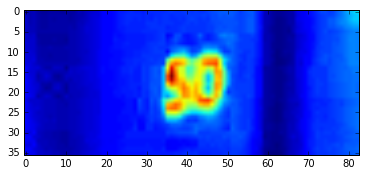

In [4]:
plt.imshow(img1_test)
print np.shape(img1_test)

In [5]:
# Use the DigitStructFile class from github.com/hangyao
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [6]:
train_digitstruct = DigitStructFile(train_struct_loc)
test_digitstruct = DigitStructFile(test_struct_loc)

In [7]:
train1_dict = train_digitstruct.getDigitStructure(0)
print train1_dict
test1_dict = test_digitstruct.getDigitStructure(0)
print test1_dict

{'name': '1.png', 'top': [77.0, 81.0], 'label': [1.0, 9.0], 'width': [81.0, 96.0], 'height': [219.0, 219.0], 'left': [246.0, 323.0]}
{'name': '1.png', 'top': [7.0], 'label': [5.0], 'width': [19.0], 'height': [30.0], 'left': [43.0]}


In [8]:
# Now, lets mess with the 1 image to crop to the bounding box.
def crop_dims(img_dict):
    mintop = int(np.min(img_dict['top']))
    top = int(mintop - np.ceil(0.1*mintop))
    minleft = int(np.min(img_dict['left']))
    left = int(minleft - np.ceil(0.1*minleft))
    total_height = int(np.max(img_dict['height']))
    height = int(total_height + np.ceil(0.05*total_height))
    total_width = int(np.sum(img_dict['width']))
    width = int(total_width + np.ceil(0.15*total_width))
    bottom = mintop + height
    right = minleft + width
    return [top, left, bottom, right]

In [9]:
train1_dims = crop_dims(train1_dict)
test1_dims = crop_dims(test1_dict)
print train1_dims
print test1_dims

[69, 221, 307, 450]
[6, 38, 39, 65]


In [10]:
# img1_crop = img1[min_top1:bottom1,min_left1:right1]
img1_crop = img1[train1_dims[0]:train1_dims[2],train1_dims[1]:train1_dims[3]]
img1_test_crop = img1_test[test1_dims[0]:test1_dims[2],test1_dims[1]:test1_dims[3]]

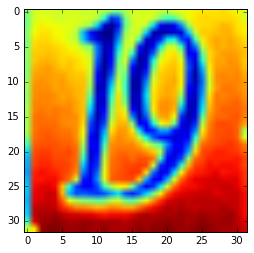

In [11]:
# Crop to 32x32
img1_rs = misc.imresize(img1_crop, (32,32))
plt.imshow(img1_rs)

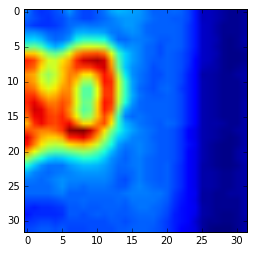

In [12]:
img1_test_rs = misc.imresize(img1_test_crop, (32,32))
plt.imshow(img1_test_rs)

The following code reads the images and crops according to the steps above. Then it encodes the label for each of these pieces of data.

In [13]:
# This function extracts and crops the indexed image.
def extract_and_crop(img_loc, img_dict, resize):
    curr_img = img.imread(img_loc + img_dict['name'],mode='L')
    img_shape = np.shape(curr_img)
    bb_top = np.min(img_dict['top'])
    bb_left = np.min(img_dict['left'])
    bb_height = np.max(img_dict['height'])
    bb_twidth = np.sum(img_dict['width'])
    # Add some pixel buffer before cropping.
    min_top = int( bb_top - 0.1*bb_top )
    min_left = int( bb_left - 0.1*bb_left )
    if min_left < 0:
        min_left = 0
    if min_top < 0:
        min_top = 0
    # ... a little less on the height
    total_height = int( bb_height + 0.05*bb_height )
    total_width = int( bb_twidth + 0.15*bb_twidth )

    curr_img_crop = curr_img[min_top:min_top+total_height,min_left:min_left+total_width]
    img_rs = misc.imresize(curr_img_crop, (resize,resize))
    return img_rs

In [14]:
# This function takes a digit struct and creates a one hot encoding of the data.
def extract_label(img_dict, encoder, max_len):
    # Build the label data with one hot encoding.
    street_label = np.array(img_dict['label']).astype(int)
    # Replace any instances of 10 with 0 - needed for one-hot encoding.
    street_label[street_label == 10] = 0
    curr_len = np.shape(street_label)[0]
    len_onehot = encoder.fit_transform(curr_len)
    y_onehot = np.concatenate((len_onehot, encoder.fit_transform(street_label.reshape(-1,1))),axis=0)
    # Create the padding for MAX_LENGTH - curr_len
    if max_len - curr_len > 0:
        nodigit_padding = np.array([10 for i in range(max_len-curr_len)])
        padding_onehot = encoder.fit_transform(nodigit_padding.reshape(-1,1))
        y_onehot = np.concatenate((y_onehot, padding_onehot), axis=0)
    return y_onehot

In [15]:
def generate_svhn_dataset(file_loc, n_vals, n_labels, crop_size, max_len):
    # Load from the digitstruct mat file.
    fname = os.path.join(file_loc, "digitStruct.mat")
    digitstruct = DigitStructFile(fname)
    data_len = len(digitstruct.digitStructName)
    X = np.zeros((data_len, crop_size, crop_size))
    y = np.zeros((data_len, n_labels, n_vals))

    invalid_idxs = []
    # Encoder for label generation.
    enc = skproc.OneHotEncoder(n_values=n_vals,sparse=False)
    for i in range(data_len):
        curr_dict = digitstruct.getDigitStructure(i)
        street_num_len = len(np.array(curr_dict['label']))
#         print i
        if street_num_len <= 5 and street_num_len > 0:
            # Extract the label
            curr_y = extract_label(curr_dict, enc, max_len)
            curr_X = extract_and_crop(file_loc, curr_dict, crop_size)
            y[i,:,:] = curr_y
            X[i,:,:] = curr_X
        else:
            invalid_idxs.append(i)
            print "Invalid number! Index = " + str(i)
    X = np.delete(X,invalid_idxs,axis=0)
    y = np.delete(y,invalid_idxs,axis=0)
    return { 'data' : X, 'labels' : y }

In [16]:
def pickle_svhn(name, dataset):
    fname = "svhn_" + name + ".pkl"
    svhn_pkl_file = open(fname, 'wb')
    pkl.dump(dataset, svhn_pkl_file, -1)
    svhn_pkl_file.close()
    
def load_svhn_pkl(fname):
    svhn_pkl_file = open(fname, 'rb')
    loaded_dataset = pkl.load(svhn_pkl_file)
    svhn_pkl_file.close()
    return loaded_dataset

Invalid number! Index = 29929
(33401, 32, 32)
(33401, 6, 11)


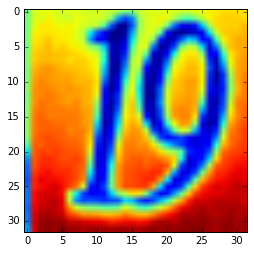

In [17]:
# Load and process the training data!
train_dataset = generate_svhn_dataset(train_loc_root, 11, 6, 32, 5)
print np.shape(train_dataset['data'])
print np.shape(train_dataset['labels'])
plt.imshow(train_dataset['data'][0])

In [18]:
# Send this data set to pkl
pickle_svhn("train", train_dataset)

(13068, 32, 32)
(13068, 6, 11)


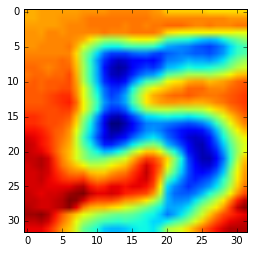

In [19]:
# Now the test data!
test_dataset = generate_svhn_dataset(test_loc_root, 11, 6, 32, 5)
print np.shape(test_dataset['data'])
print np.shape(test_dataset['labels'])
plt.imshow(test_dataset['data'][0])

In [20]:
pickle_svhn("test", test_dataset)